This script calculates the linear regression and correction factor of all winkler samples. 
CF is calculated by matching neutral density of CTD files with sigma-theta from Winkler samples. 

In [38]:
# Let's find the linear regression for all stations: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import colorcet as ccmport 
import seaborn as sns
import colorcet as cc
# Get CSV files list from a folder
path ='/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/Log/'
csv_files = glob.glob(path + "/*.csv")

# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
stations_df = pd.concat(df_list)

#Create a bottle file with all winkler values and other parameters measured when sampling:
#stations_df.to_csv('bottlefile_hly2202.csv')

#Calculating potential density for each bottle sample drawn:
stations_df['sigma-theta']= stations_df['Sigma']*1000 - 1000


Matching sigma-thetha Winkler density with Thermo_NeutralDensity from CTD files:
1. Need to import "pre" ctd sensor files from station 0 to station 8 with different table format. (First CTD O2 sensor)
2. then, I import the "post" sensor files from station 11 to station 53 (Second CTD O2 sensor)


Importing all CTD files in .cnv format. Concatenating them into one single dataframe "all_df"

In [2]:
#Import required packages:
import matplotlib.pyplot as plt
from pathlib import Path

#Define path name for pre ctd files#
#path1 = Path("/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/CTD_Northbound/")
#csv_files1 = path1.glob("*Pre1dbar.cnv")

#import pre ctd files
#pre_list = [pd.read_csv(file, encoding="ISO-8859-1", delim_whitespace=True, skiprows=319, header=None)
              # .assign(filename=file.stem.split("_")[1]) for file in csv_files1]
#pre_df = pd.concat(pre_list) #concat pre ctd files

#Define path name for post ctd files/Northbound
path2 = Path("/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/CTD_Northbound/")
csv_files2 = path2.glob("*Pcaldown1dbar.cnv")

#import post Northbound ctd files
postnorth_list = [pd.read_csv(file2, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(filename=file2.stem.split("_")[1]) for file2 in csv_files2]

postnorth_df = pd.concat(postnorth_list) #concat post northbound ctd files

#Define path name for post ctd files/Southbound
path3 = Path("/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/CTD_Southbound/")
csv_files3 = path3.glob("*Pcaldown1dbar.cnv")

#import post Southbound ctd files
postsouth_list = [pd.read_csv(file3, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(filename=file3.stem.split("_")[1]) for file3 in csv_files3]

postsouth_df = pd.concat(postsouth_list) #concat post southbound ctd files

# Concatenate all DataFrames
all_df = pd.concat([postnorth_df, postsouth_df])

We will use TEOS-10 for our analysis.
gsw package is used to calculate Absolute Salinity g/kg and Conservative Temperature.

Since neutral density can't be calculated at high latitudes (<64N), we are exploring Thermodynamic neutral density by Remi Tailleux, U. of Reading,

In [3]:
import gsw
from gsw_gammat_analytic_CT_exact import gsw_gammat_analytic_CT_exact

#Calculate Reference Composition Salinity and Conservative Temperature

all_df['SA'] = gsw.SA_from_SP(all_df[4], all_df[0],all_df[20],all_df[19]) 


#Calculating Conservative Temperature from potential temperature
all_df['theta'] = gsw.pt0_from_t(all_df['SA'],all_df[2],all_df[0])
all_df['CT'] = gsw.conversions.CT_from_pt(all_df['SA'],all_df['theta']) #conservative temperature ITS-90

#Calculate potential density
#all_df['sigma_t'] = gsw.density.sigma0(all_df['SA'], all_df['CT'])

#Calculate gamma_T Tailleux routine:
all_df['gammat_teos10'],all_df['zref_teos10'],all_df['pref_teos10'],all_df['sigref_teos10'] = gsw_gammat_analytic_CT_exact(all_df['SA'],all_df['CT'])

Matching Winkler sigma-theta values with ctd GammaT values (from CTD) to get a CF.


In [40]:
#Creating a new dataframe with matched values 
all_df.rename(columns={'filename':'Station #'}, inplace=True)
all_df['Station #'] = all_df['Station #'].astype(np.int64)
stations_df['Station #'] = stations_df['Station #'].fillna(0).astype(np.int64)
stations_df.dropna(subset=['sigma-theta'], inplace=True)
merged_sigma = pd.merge_asof(stations_df.sort_values('sigma-theta',ascending=True), all_df.sort_values('gammat_teos10', ascending=True), by='Station #',left_on='sigma-theta', right_on='gammat_teos10',allow_exact_matches=True, direction='nearest')
merged_sigma['CF'] = merged_sigma['Winkler umol/kg']/merged_sigma[16]
merged_sigma['CF'].mean

<bound method Series.mean of 0      1.035307
1      1.033877
2      1.024540
3      1.023600
4      1.025481
         ...   
843    0.961611
844    0.962869
845    0.961773
846    0.964070
847    0.968491
Name: CF, Length: 848, dtype: float64>

Using the mean value of the correction factor we can correctd ctd oxygen values.
CF mean = 1.035307

In [27]:
#Correcting CTD O2 values: 
all_df['O2_correct']= all_df[16]*1.035307


Now let's do Linear Regression

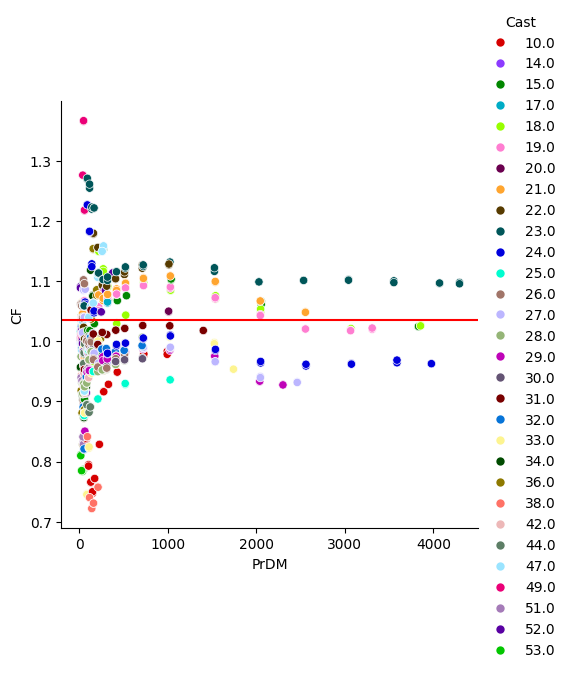

In [28]:

#custom_palette = sns.color_palette("viridis", 29)
palette = sns.color_palette(cc.glasbey, n_colors=30)

sns.relplot(x='PrDM',
            y='CF',
            data=merged_sigma,
            kind='scatter',
            hue='Cast', legend='full', palette=palette)

plt.axhline(y=1.035307, color='r', linestyle='-')

plt.show()

Text(250, 400, 'CF Mean = 1.035307 ')

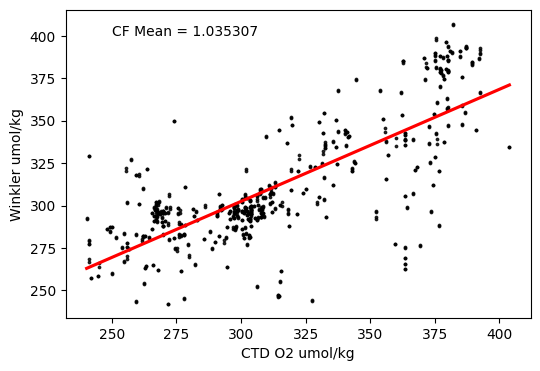

In [102]:
import scipy as sp
linreg = sp.stats.linregress(merged_sigma[16], merged_sigma['Winkler umol/kg'])

#plt.scatter(merged_sigma[16], merged_sigma['Winkler umol/kg'], color = )
#plt.plot(np.arange(-1,4,0.1), linreg.slope*np.arange(-1,4,0.1)+linreg.intercept, 'r')
#plt.text(3, 2, "R$^2$=" + str( (np.round(linreg.rvalue**2*100)/100)) )
#plt.text(3, 1.75, "p-value=" + str(linreg.pvalue) )

palette = sns.color_palette(cc.glasbey, n_colors=30)
fig,ax = plt.subplots(figsize=(6,4))
ax = sns.regplot(x=merged_sigma[16],
            y=merged_sigma['Winkler umol/kg'],scatter_kws={'s':3}
            ,color= "0", ci=None, line_kws=dict(color="r"))
ax.set_xlabel("CTD O2 umol/kg")
ax.text(250, 400,'CF Mean = 1.035307 ', fontsize = 10)

In [64]:
merged_sigma['Winkler umol/kg'].shape, merged_sigma[16].shape

((848,), (848,))

Investigating if correction works at station 15

In [41]:
#Convert Station # column to int64
all_df['Station #'] = pd.to_numeric(all_df['Station #'])
#Selecting only CTD Cast 15, matches with Canadian cruise
station15  = all_df.loc[all_df['Station #'] == 15]

compare = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/d2022-045-0022.cnv', encoding="ISO-8859-1", delim_whitespace=True, skiprows=569, header=None)
#Calculate SA, CT #Can't calculate, file does not contain density, latitude and longitude t caculate TEOS-10
#compare['SA'] = gsw.SA_from_SP(compare[4], compare[1],compare[20],compare[19]) 
#compare['CT'] = gsw.conversions.CT_from_pt(compare['SA'],compare[20]) #conservative temperature ITS-90
#Calculate in-situ density and sigma theta

#Will use EOS-80 for this purposes
compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
compare['sigma-den'] = compare['density-rho'] - 1000

oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)

#Selecting Winkler values from station 15
#stations_df['Station #'] = pd.to_numeric(stations_df['Station #'])
Winkler_S15 = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/Log/HEALY2202_S13C15.csv')

Text(0.5, 1.0, 'Station 15')

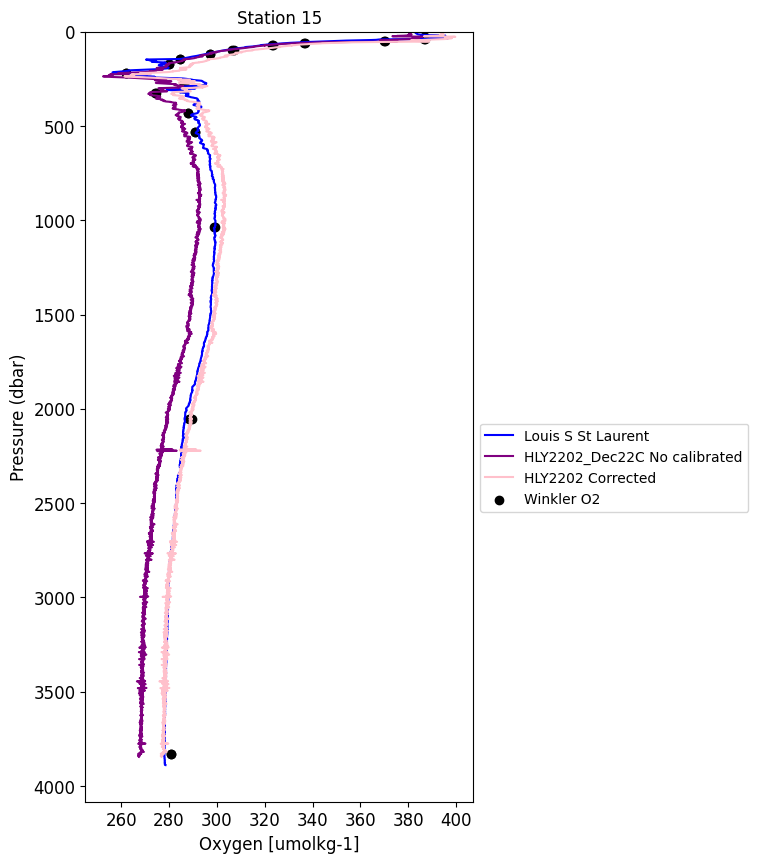

In [42]:
# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(oxy,compare[1],color='blue', markersize=0.5, label= 'Louis S St Laurent')
plt.plot(station15[16],station15[0],color='purple', markersize=0.1, label= 'HLY2202_Dec22C No calibrated')
plt.plot(station15['O2_correct'],station15[0],color='pink', markersize=0.1, label= 'HLY2202 Corrected')
#plt.plot(station15['CFO2_above500'],station15[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station15['CFO2_below500'],station15[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
plt.scatter(Winkler_S15['Winkler umol/kg'],Winkler_S15['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Station 15')

Let's see how the North Pole station looks like compared to Geotraces file

Text(0.5, 1.0, 'North Pole')

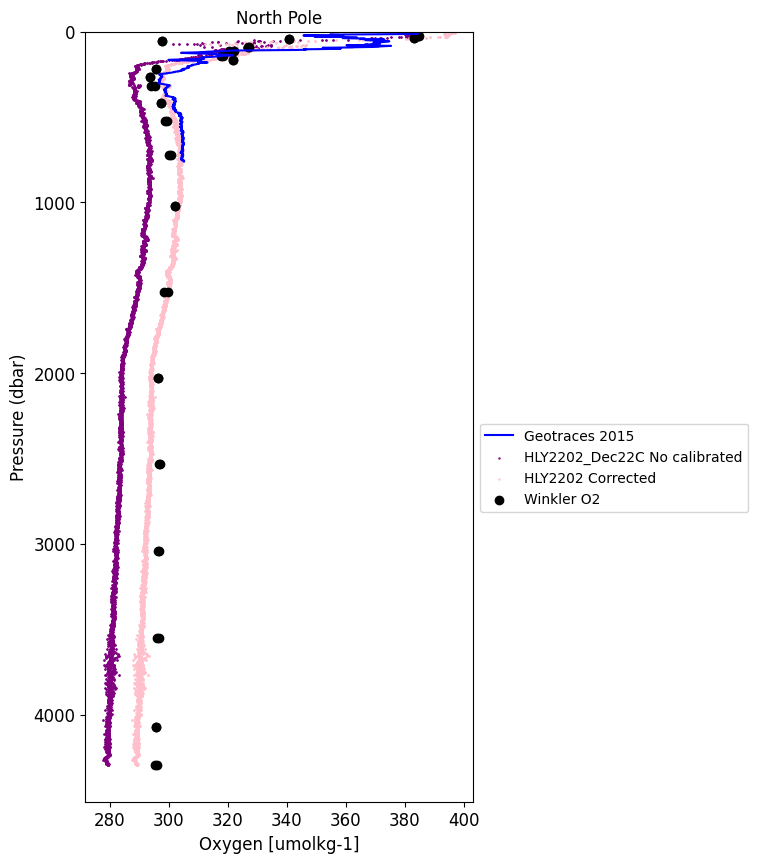

In [52]:
#Selecting only CTD North Pole Cast
station23  = all_df.loc[all_df['Station #'] == 23]
import xarray as xr
geo_lat90 = xr.open_dataset('/Users/mariacristinaalvarez/Documents/NorthPoleO2/Geotraces2015/East/33HQ20150809_00032_00004_ctd.nc')
#Calculate SA, CT #Can't calculate, file does not contain density, latitude and longitude t caculate TEOS-10
#compare['SA'] = gsw.SA_from_SP(compare[4], compare[1],compare[20],compare[19]) 
#compare['CT'] = gsw.conversions.CT_from_pt(compare['SA'],compare[20]) #conservative temperature ITS-90
#Calculate in-situ density and sigma theta

#Will use EOS-80 for this purposes
#compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
#compare['sigma-den'] = compare['density-rho'] - 1000

#oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)

#Selecting Winkler values from station 15
#merged_sigma['Station #'] = pd.to_numeric(merged_sigma['Station #'])
Winkler_S23 = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/Log/HEALY2202_S21C23.csv')

# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(geo_lat90.oxygen,geo_lat90.pressure,color='blue', markersize=0.5, label= 'Geotraces 2015')
plt.scatter(station23[16],station23[0],color='purple', s= 0.5,label= 'HLY2202_Dec22C No calibrated')
plt.scatter(station23['O2_correct'],station23[0],color='pink', s= 0.5,label= 'HLY2202 Corrected')
#plt.plot(station23['CFO2_above500'],station23[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station23['CFO2_below500'],station23[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
plt.scatter(Winkler_S23['Winkler umol/kg'],Winkler_S23['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('North Pole')

In [47]:
geo_lat90

<xarray.Dataset>
Dimensions:         (pressure: 761, time: 1, latitude: 1, longitude: 1)
Coordinates:
  * pressure        (pressure) float64 0.0 1.0 2.0 3.0 ... 758.0 759.0 760.0
  * time            (time) datetime64[ns] 2015-09-06T03:43:00
  * latitude        (latitude) float32 89.99
  * longitude       (longitude) float32 28.84
Data variables: (12/19)
    pressure_QC     (pressure) int16 ...
    temperature     (pressure) float64 ...
    temperature_QC  (pressure) int16 ...
    salinity        (pressure) float64 ...
    salinity_QC     (pressure) int16 ...
    oxygen          (pressure) float64 386.4 385.8 385.4 ... 305.2 305.1 305.1
    ...              ...
    CTDNOBS         (pressure) float64 ...
    CTDETIME        (pressure) float64 ...
    woce_date       (time) int32 ...
    woce_time       (time) int16 ...
    station         |S40 ...
    cast            |S40 ...
Attributes:
    EXPOCODE:                   33HQ20150809
    Conventions:                COARDS/WOCE
    WOCE_VERSION:               3.0
    WOCE_ID:                    ARC01
    DATA_TYPE:                  WOCE CTD
    STATION_NUMBER:             32
    CAST_NUMBER:                4
    BOTTOM_DEPTH_METERS:        4239
    Creation_Time:              2017-07-06T15:12:05.542781Z
    ORIGINAL_HEADER:            CTD,20170706CCHSIOSEE\n# SHIP: Healy \n# Crui...
    WOCE_CTD_FLAG_DESCRIPTION:  ::1 = Not calibrated:2 = Acceptable measureme...

In [94]:
merged_sigma

,Unnamed: 0,Station #,Cast,Pressure(dbar),Niskin,Bottle,Draw T,Date,Sal00,Sal11,...,23,filename,SA,theta,CT,gammat_teos10,zref_teos10,pref_teos10,sigref_teos10,CF
0,2.0,15.0,17.0,NaN,17.0,T23,-1.1,9/19/22,27.0938,27.0937,...,0.0,11,27.215085,-0.577170,-0.555792,21.747007,7.229565,7.241727,21.777005,1.042237
1,3.0,15.0,17.0,NaN,17.0,CU-49,-1.1,9/19/22,27.0938,27.0937,...,0.0,11,27.215085,-0.577170,-0.555792,21.747007,7.229565,7.241727,21.777005,1.040797
2,3.0,11.0,NaN,NaN,18.0,B12,-0.9,9/16/22,27.2526,27.2535,...,0.0,11,27.374293,-0.559740,-0.538442,21.875322,8.125061,8.139398,21.908967,1.024540
3,2.0,11.0,NaN,NaN,18.0,CU-1,-0.9,9/16/22,27.2526,27.2535,...,0.0,11,27.374293,-0.559740,-0.538442,21.875322,8.125061,8.139398,21.908967,1.023600
4,39.0,16.0,18.0,NaN,24.0,B3,-0.1,9/19/22,27.7181,27.7189,...,0.0,36,27.802588,-1.230611,-1.216779,22.234864,11.000281,11.022326,22.280231,1.036544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,6.0,22.0,24.0,2542.7,5.0,CU-75,-1.4,10/4/22,34.9393,34.9387,...,0.0,36,34.626547,-0.117204,-0.114813,28.119071,3324.120928,3375.405362,43.182008,1.120488
844,4.0,22.0,24.0,3056.4,4.0,3,-1.4,10/4/22,34.9410,34.9406,...,0.0,48,34.631233,-0.101074,-0.098711,28.121024,3344.120424,3395.872976,43.273580,1.123686
845,5.0,22.0,24.0,3056.4,4.0,T7,-1.4,10/4/22,34.9410,34.9406,...,0.0,48,34.631233,-0.101074,-0.098711,28.121024,3344.120424,3395.872976,43.273580,1.122408
846,3.0,22.0,24.0,3571.4,3.0,CU-3,-1.6,10/4/22,34.9417,34.9413,...,0.0,20,34.610464,-0.236278,-0.233759,28.127884,3414.473724,3467.887268,43.595495,1.059322


In [96]:
all_df['filename' ==15]

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
       ...  
704    709.0
705    710.0
706    711.0
707    712.0
708    713.0
Name: 0, Length: 45333, dtype: float64